# Efficient Asset Allocation
 
<p> An efficient portfolio gives us the best possible return for a given level of risk. Here we will find the best porfolios for either a desired return or risk tolerance.  </p>

### Import Modules and Get the Data
<p> 
We have a bunch of stock data from Yahoo finance. Let's choose the companies we want to analyze, read in their historical stock data, and calculate their return rate for each time period. Here, we have monthly stock prices from 11/2000 - 11/2016 for Apple, General Electric, Coca Cola, Bank of America, and Microsoft.
</p>

In [1]:
import pandas as pd
import numpy as np
import os
from itertools import permutations,combinations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

data_dir = os.getcwd() + '\\stock_data'
results_dir = os.getcwd() + '\\Results'

In [2]:
#Read in all the stock data
data = []
get_companies = ['AAPL','GE','KO','BAC','MSFT']
for f in os.listdir(data_dir):
    if f.strip('.csv') in get_companies:
        df = pd.read_csv(data_dir + '\\' +f)
        df['Date'] = pd.to_datetime(df['Date'])
        data.append((f.strip('.csv'),df.sort_values('Date')))
        print 'Got data for %s' %f.strip('.csv')

Got data for AAPL
Got data for BAC
Got data for GE
Got data for KO
Got data for MSFT


In [3]:
dates = data[0][1]['Date']
adj_close = pd.DataFrame({'Date':dates})
pct_returns = pd.DataFrame({'Date':dates})
for i,j in data:
    adj_close[i] = j['Adj Close']
    pct_returns[i] = j['Adj Close'].pct_change(periods=1)
    
pct_returns = pct_returns[pct_returns.iloc[:,1].notnull()].iloc[:,1:]
adj_close = adj_close.iloc[:,1:]

In [4]:
print 'Dates:\n'
print dates.head()
print '\nAdj Close:\n'
print adj_close.head()
print '\nPercent Return:\n'
print pct_returns.head()

Dates:

192   2000-11-06
191   2000-12-01
190   2001-01-02
189   2001-02-01
188   2001-03-01
Name: Date, dtype: datetime64[ns]

Adj Close:

         AAPL        BAC         GE         KO       MSFT
192  1.073501  13.171493  29.878254  20.552505  19.610468
191  0.967777  15.129696  28.992708  19.998695  14.825342
190  1.406936  17.749977  27.808807  19.034655  20.870834
189  1.187357  16.905066  28.123304  17.403582  20.165884
188  1.435888  18.255470  25.408234  14.874217  18.691895

Percent Return:

         AAPL       BAC        GE        KO      MSFT
191 -0.098485  0.148670 -0.029638 -0.026946 -0.244009
190  0.453781  0.173188 -0.040834 -0.048205  0.407781
189 -0.156069 -0.047601  0.011309 -0.085690 -0.033777
188  0.209314  0.079882 -0.096542 -0.145336 -0.073093
187  0.154962  0.022831  0.159341  0.022808  0.238857


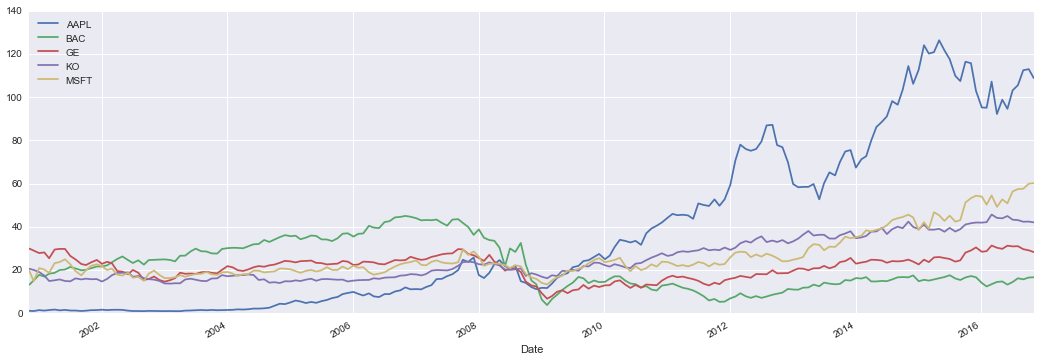

In [5]:
adj_close.plot(x=dates,figsize=(18,6))
plt.legend(loc=2)
plt.show()

### Generate Valid Portfolio Weights
<p> Let's say we want our portfolio to consist of 3 companies. Here, we can identify the number of different combinations available to us for our choice of assets. We also calculate the possible portfolios *for each* combination of assets. For example, if we want Apple, Coke, and General Eletric in our portfolio, one possible scenario is 30% Apple, 20% Coke, and 50% GE. In our example here, there are 10 possible asset combinations and 4508 possible asset allocations for each combination.
</p>

In [6]:
n_companies = 3
min_weight = 1            #the least amount we can own of a single company ex. 1 means 1%
weights = [x/float(100.0) for x in range(min_weight,101 - min_weight)]
valid_weights = [p for p in permutations(weights,n_companies) if sum(np.array(p)) == 1]

print 'Using %i total companies with %i companies per portfolio.\n' %(len(pct_returns.columns),n_companies)
print 'Posssible portfolio combinations: %i' %len([c for c in combinations(pct_returns.columns.values,n_companies)])
print [c for c in combinations(pct_returns.columns.values,n_companies)]

print '\nPossible weighting scenarios for each portfolio: %i' %len(valid_weights)
print str(valid_weights[:20]) + '   etc...'

Using 5 total companies with 3 companies per portfolio.

Posssible portfolio combinations: 10
[('AAPL', 'BAC', 'GE'), ('AAPL', 'BAC', 'KO'), ('AAPL', 'BAC', 'MSFT'), ('AAPL', 'GE', 'KO'), ('AAPL', 'GE', 'MSFT'), ('AAPL', 'KO', 'MSFT'), ('BAC', 'GE', 'KO'), ('BAC', 'GE', 'MSFT'), ('BAC', 'KO', 'MSFT'), ('GE', 'KO', 'MSFT')]

Possible weighting scenarios for each portfolio: 4508
[(0.01, 0.02, 0.97), (0.01, 0.03, 0.96), (0.01, 0.04, 0.95), (0.01, 0.05, 0.94), (0.01, 0.06, 0.93), (0.01, 0.07, 0.92), (0.01, 0.08, 0.91), (0.01, 0.09, 0.9), (0.01, 0.1, 0.89), (0.01, 0.11, 0.88), (0.01, 0.12, 0.87), (0.01, 0.13, 0.86), (0.01, 0.14, 0.85), (0.01, 0.15, 0.84), (0.01, 0.16, 0.83), (0.01, 0.17, 0.82), (0.01, 0.18, 0.81), (0.01, 0.19, 0.8), (0.01, 0.2, 0.79), (0.01, 0.21, 0.78)]   etc...


### Define some functions we will need
<p>To find our efficient portfolios we will need the variance-covariance matrix for the companies involved. possible_portfolios will compute the mean return, variance, and volatility for every valid weighting of assets in a portfolio and find_efficient_frontier will give use those results to give us only efficient portfolios. Complete report will write an excel for each portfolio. All output files will be saved in a folder called "Results". While we're here let's also check out the correlation table to see which companies tend to move together in price. 
</p>

In [7]:
#Var-covar matrix
def get_var_covar_matrix(returns):
    return pd.DataFrame(np.cov(returns.transpose()),index=returns.columns,columns=returns.columns)
get_var_covar_matrix(pct_returns)

,AAPL,BAC,GE,KO,MSFT
AAPL,0.011973,0.002712,0.002063,0.000779,0.003933
BAC,0.002712,0.014139,0.004938,0.001121,0.003299
GE,0.002063,0.004938,0.005684,0.001365,0.002580
KO,0.000779,0.001121,0.001365,0.002291,0.000918
MSFT,0.003933,0.003299,0.002580,0.000918,0.006383


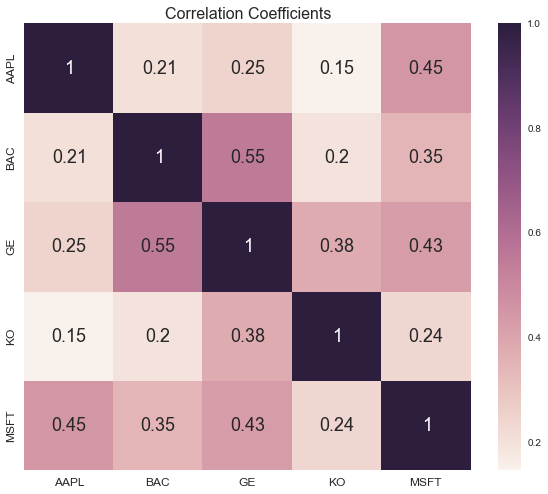

In [10]:
#Corr Coef
fig = plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(np.corrcoef(pct_returns.transpose()),index=pct_returns.columns,columns=pct_returns.columns),
            annot=True,annot_kws={"size":18})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Correlation Coefficients',fontsize=16)
plt.show()

In [11]:
#Create df of every weighting scenario
def possible_portfolios(valid_weights,var_covar_m,means):
    var,vol,ret = [],[],[]
    for combo in valid_weights:
        variance = (np.matrix((np.matrix(combo) * np.matrix(var_covar_m))) * np.matrix(combo).transpose()).A1[0]
        mean_return = (np.matrix(combo) * np.matrix(means).transpose()).A1[0]
        var.append(variance)
        vol.append(np.sqrt(variance))
        ret.append(mean_return)
    possibles = pd.DataFrame(valid_weights,columns= var_covar_m.columns.values)
    possibles = possibles.join(pd.DataFrame({'Variance':var,'Volatility':vol,'Mean Return':ret}))
    return possibles

In [12]:
#Finds the optimal portfolios from a dataframe of all possible portfolios
def find_efficient_frontier(all_portfolios):
    #Assign each volatility a bracket-- the volatility rounded to the nearest thousandth
    all_portfolios['Vol_bracket'] = all_portfolios['Volatility'].apply(lambda x: round(x,3))
    all_portfolios['Ret_bracket'] = all_portfolios['Mean Return'].apply(lambda x: round(x,3))
    optimals = []
    current_max_return = 0
    #For a given volatility bracket get the one with the highest return;
    #ALso run a check to see if the current volatilty's max return is higher than the max returns for lower volatilies;
    #    if it is not, then it is not optimal
    for vol in np.sort(all_portfolios['Vol_bracket'].unique()):
        vol_group = all_portfolios[all_portfolios['Vol_bracket'] == vol]
        if vol_group['Mean Return'].max() > current_max_return:
            optimals.append(vol_group[vol_group['Mean Return'] == vol_group['Mean Return'].max()])
            current_max_return = vol_group['Mean Return'].max()
    return pd.concat(optimals).sort_values('Vol_bracket')

In [13]:
def complete_report(ret,mean_ret,var_covar,possibles,efficients,companies):
    writer = pd.ExcelWriter(results_dir + '\\Optimal_Portfolio_%s' %','.join(companies) + '.xlsx')
    ret.to_excel(writer, sheet_name='Percent Returns')
    mean_ret.to_excel(writer, sheet_name='Avg Returns')
    var_covar.to_excel(writer, sheet_name='Var-Covar Matrix')
    possibles.to_excel(writer, sheet_name='Possible Portfolios')
    efficients.to_excel(writer, sheet_name='Efficient Portfolios')
    writer.save()

### Find Efficient Portfolios

<p>Now we will create a big collection of all the optimal/efficient portfolios that we can search later. It will be used to return a portfolio based on the user's risk/return criteria.
</p>

In [14]:
#Find the efficient portfolios for every combination of companies and writes it to excel 
#also stores all the optimal portfolios in all_optimals which will be used below
all_optimals = []
for i in combinations(pct_returns.columns.values,n_companies):
    companies = list(i)
    var_covar = get_var_covar_matrix(pct_returns[companies])                   
    means = pd.DataFrame(pct_returns[companies].mean()).transpose()                                     
    possibles = possible_portfolios(valid_weights,var_covar,means) 
    
    optimals = find_efficient_frontier(possibles)                                     #find efficient frontier
    all_optimals.append(optimals)
    
    #complete_report(pct_returns[companies],means,var_covar,possibles.drop(['Vol_bracket','Ret_bracket'],axis=1),
     #               optimals.drop(['Vol_bracket','Ret_bracket'],axis=1),companies)

### Find Portfolio by User Criteria
<p>Now that we have the efficient portfolios for every company, let's allow a user to give either their risk tolerance or desired returns and show them the best decision for their preference. For example, lets say you would like returns of 5%. There are many combinations of companies that can achieve this but we would like to see the ones that give us this return with the minimum amount of risk. In other words, we know the optimal portfolios for a single combination of companies but we want to find the optimal companies to choose from these-- the "optimal optimals". 
</p>

In [15]:
#Returns a list of dataframe objects of the porfolio weightings that meet the user's criteria
def choose_risk_level(risk,all_optimals=all_optimals,save_results=False):
    chosens = []
    for portfolios in all_optimals:
        chosen = portfolios[portfolios['Vol_bracket'] == round(risk,3)]
        if len(chosen):
            chosens.append(chosen.drop(['Vol_bracket','Ret_bracket'],axis=1))  
    #If there are results, show them sorted by highest return
    if len(chosens):
        print pd.concat(chosens).sort_values('Mean Return',ascending=False).fillna('')
        if save_results:
            pd.concat(chosens).sort_values('Mean Return',ascending=False).fillna('').to_csv(results_dir+'\\Risk_of_%s.csv' %risk)
    else:
        print "No matches."
    return chosens

def choose_returns(_return,all_optimals=all_optimals,save_results=False):
    chosens = []
    for portfolios in all_optimals:
        chosen = portfolios[portfolios['Ret_bracket'] == round(_return,3)]
        chosen = chosen[chosen['Volatility'] == chosen['Volatility'].min()]
        if len(chosen):
            chosens.append(chosen.drop(['Vol_bracket','Ret_bracket'],axis=1)) 
    #If there are results, show them sorted by smallest volatility
    if len(chosens):
        print pd.concat(chosens).sort_values('Volatility').fillna('') 
        if save_results:
            pd.concat(chosens).sort_values('Volatility').fillna('').to_csv(results_dir+'\\Returns_of_%i_pct.csv' %(ret*100))
    else:
        print "No Matches."
    return chosens

In [18]:
def plot(chosen_portfolios=None,save_results=False):         #    *This function is messy and should be fixed
    line_markers = ['b-','r-','g-','y-','m-','k-']
    for i in combinations(pct_returns.columns.values,n_companies):
        companies = list(i)
        fig = plt.figure(figsize=(16,6))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)

        for company,marker in zip(companies,line_markers):
            ax1.plot(dates,adj_close[company],marker)

        ax1.set_title('Returns Over Time')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Adj Close')
        ax1.set_ylim([0,adj_close.max().max()])
        ax1.legend(labels=companies,loc=2)

        var_covar = get_var_covar_matrix(pct_returns[companies])                    #Variance-Covariance Matrix
        means = pd.DataFrame(pct_returns[companies].mean()).transpose()                                      #Average Returns
        possibles = possible_portfolios(valid_weights,var_covar,means)                               #Volatility x Returns
        optimals = find_efficient_frontier(possibles)                                     #find efficient frontier

        ax2.plot(possibles['Volatility'],possibles['Mean Return'],'bo')                         #plot all combinations
        ax2.plot(optimals['Volatility'],optimals['Mean Return'],'yo-')              #plot the efficient frontier
        if chosen_portfolios:

            for df in chosen_portfolios:

                if set(df.columns[:n_companies]) == set(companies):
                    ax2.plot(df['Volatility'],df['Mean Return'],'r*',markersize=20)
                    ax2.text(possibles['Volatility'].max()-.01,possibles['Mean Return'].min(),
                             df.drop('Variance',axis=1),size=12)

        ax2.set_title('Volatility vs. Returns')
        ax2.set_xlabel('Risk (st.dev)')
        ax2.set_ylabel('Mean Return')
        if save_results:
            plt.savefig(results_dir+'\\'+'_'.join(companies)+'.jpg')

<p>
Let's choose a return of 3%. There are five combinations of companies that have acheived this return. We can see that our best play is 97% AAPL, 2% BAC, and 1% KO because it gives us the lowest volatility compared to all the other company combinations.
</p>

      AAPL   BAC    GE    KO  MSFT  Mean Return  Variance  Volatility
4507  0.97  0.02        0.01           0.029560  0.011392    0.106735
4507  0.97  0.02  0.01                 0.029537  0.011419    0.106860
4506  0.97              0.01  0.02     0.029569  0.011437    0.106942
4506  0.97        0.01        0.02     0.029546  0.011462    0.107063
4506  0.97  0.01              0.02     0.029605  0.011476    0.107127


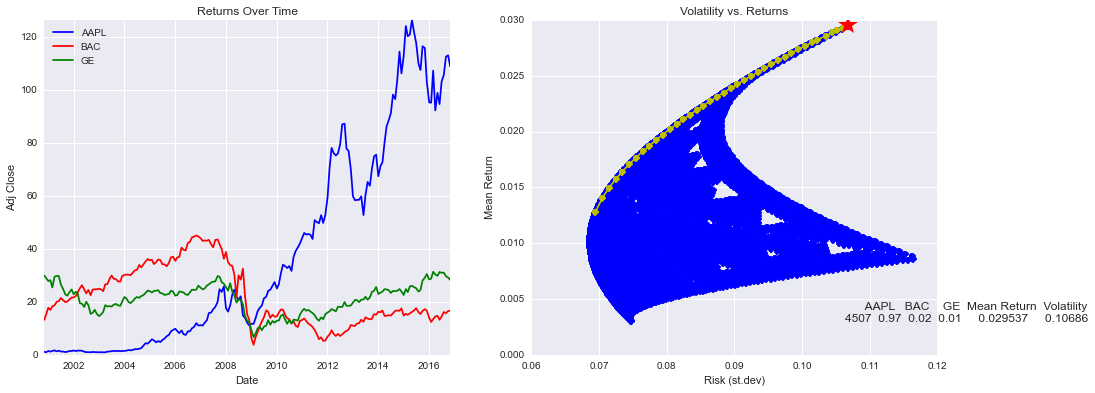

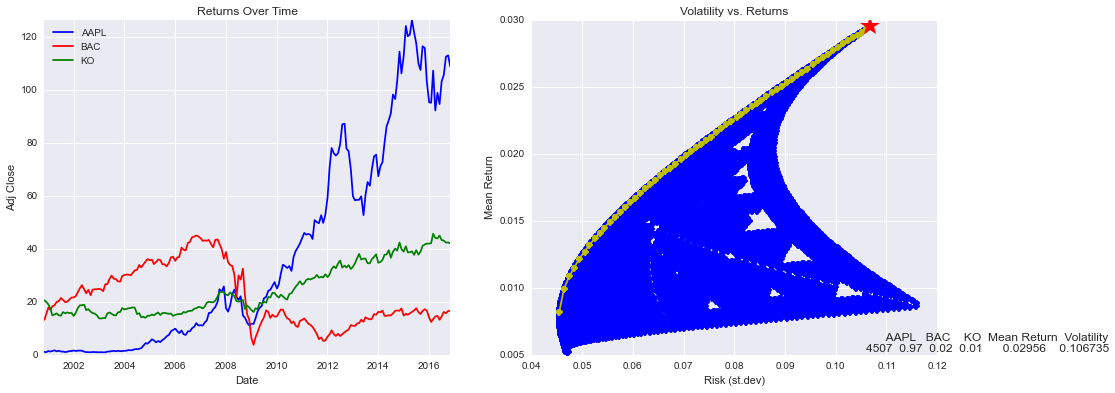

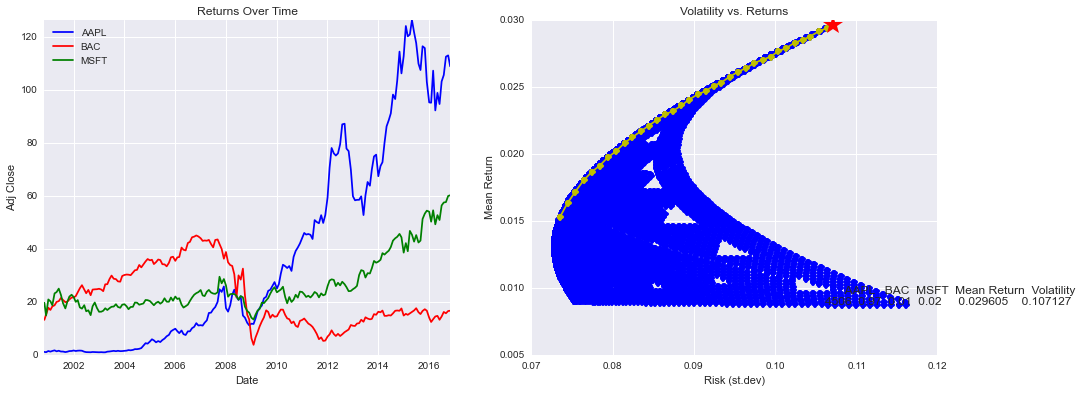

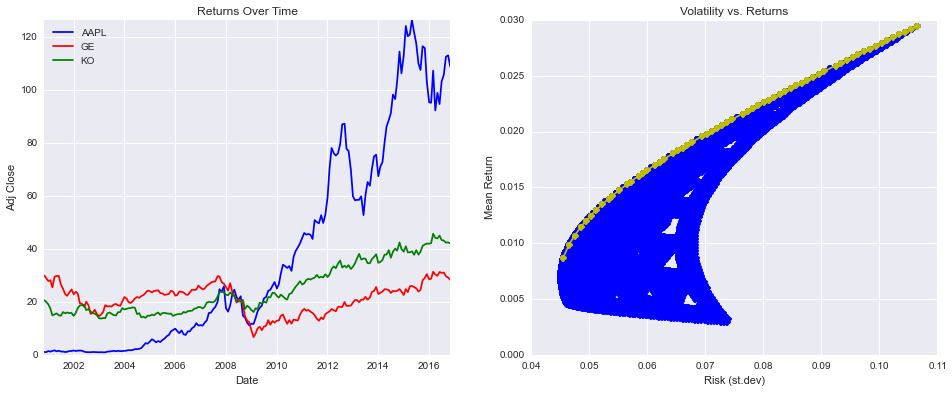

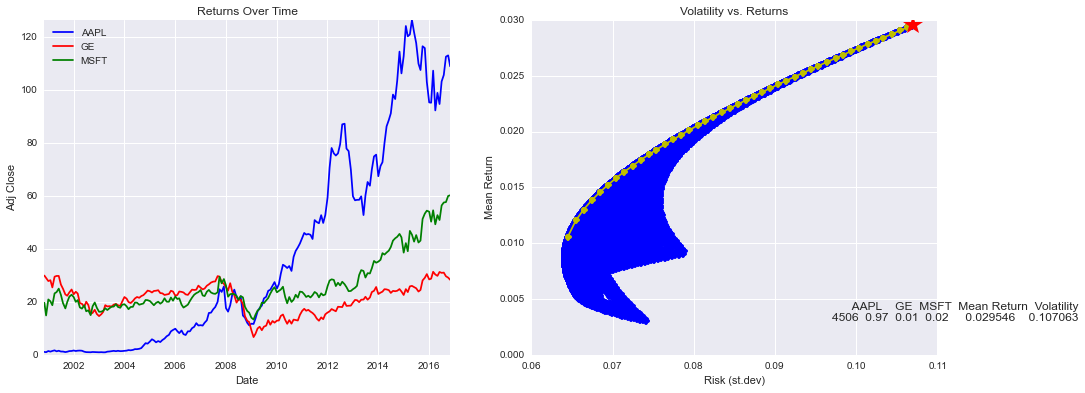

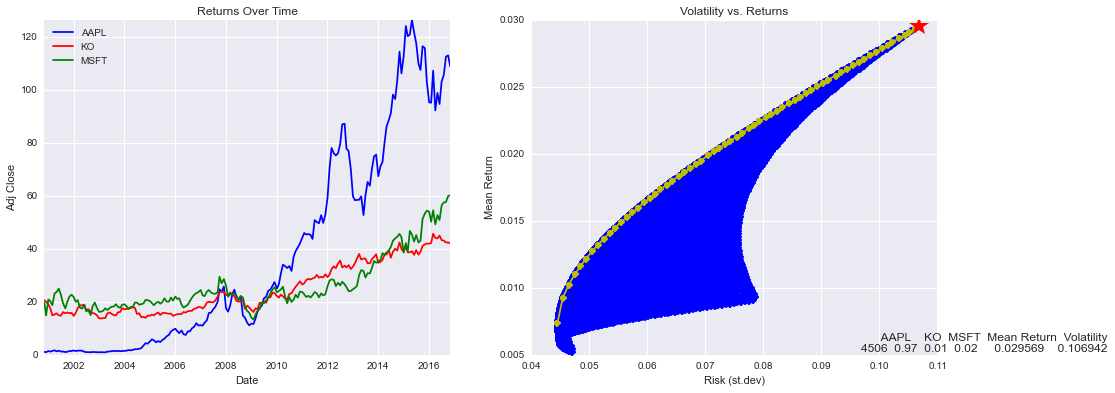

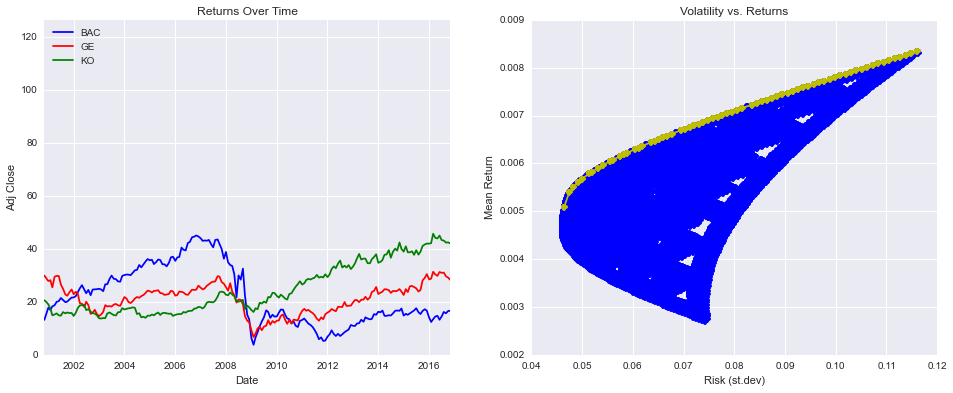

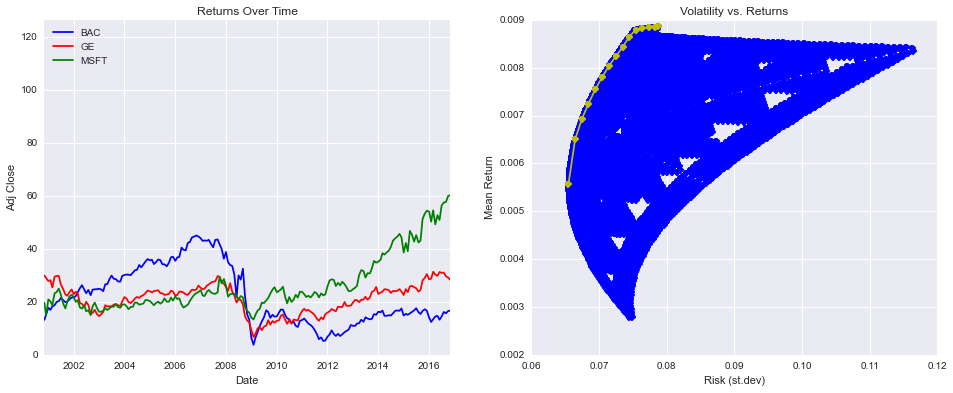

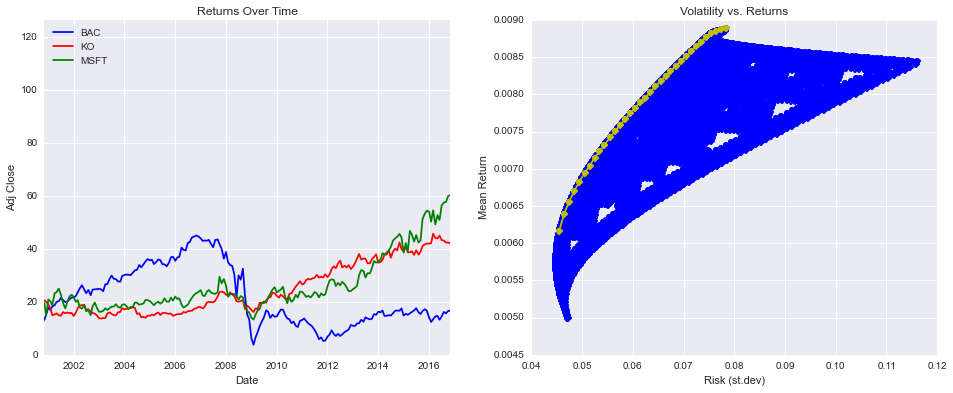

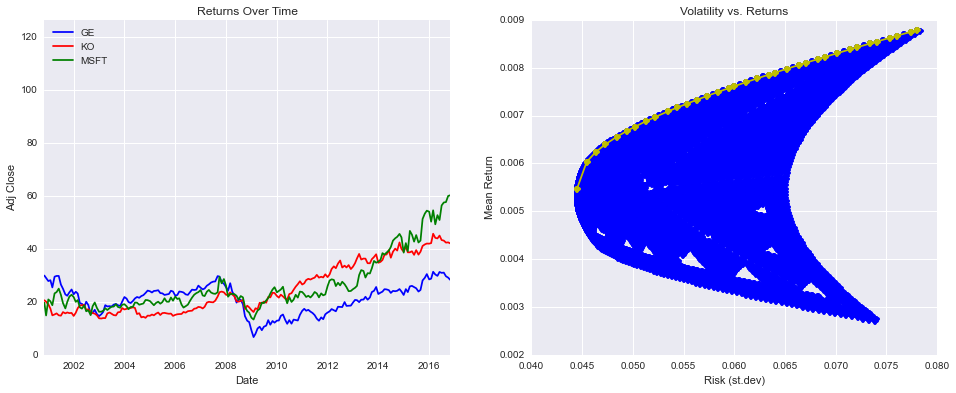

In [19]:
ret = .03
chosens = choose_returns(ret,save_results=False)
if len(chosens):
    plot(chosens,save_results=False)

<p>Or, let's say our risk tolerance is .05. There are six combinations that acheive a risk tolerance that low. We can see that our best play here is  30% AAPL, 64% KO, and 6% Microsoft because it gives us the highest return for this level of risk.
</p>

     AAPL   BAC    GE    KO  MSFT  Mean Return  Variance  Volatility
2359  0.3              0.64  0.06     0.012735  0.002550    0.050499
2310  0.3  0.06        0.64           0.012707  0.002550    0.050495
2305  0.3        0.01  0.69           0.012469  0.002523    0.050226
846         0.1        0.48  0.42     0.006944  0.002550    0.050496
50               0.01  0.52  0.47     0.006764  0.002517    0.050170
1822       0.23  0.01  0.76           0.005685  0.002507    0.050070


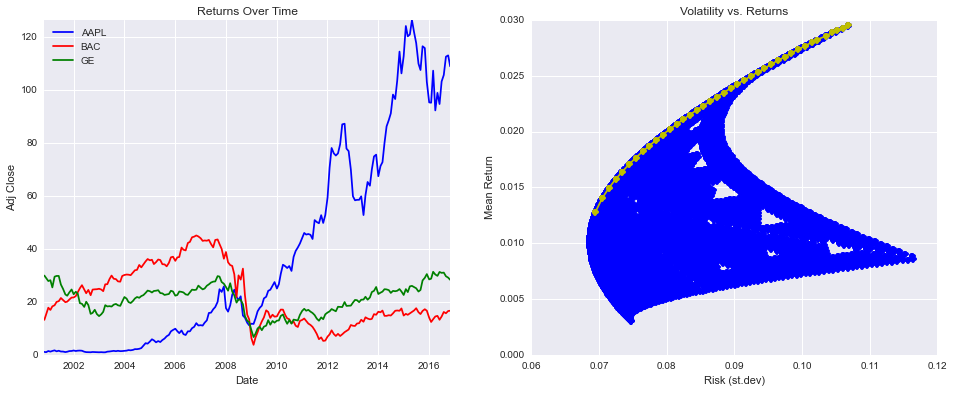

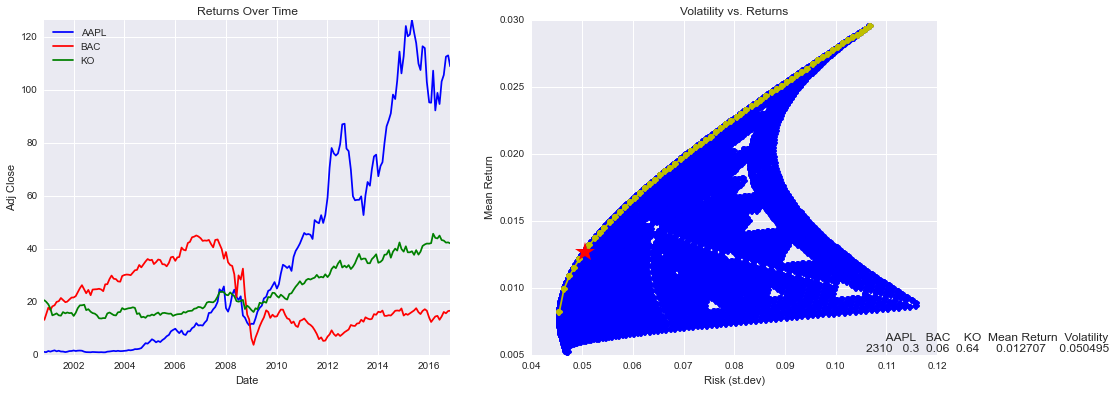

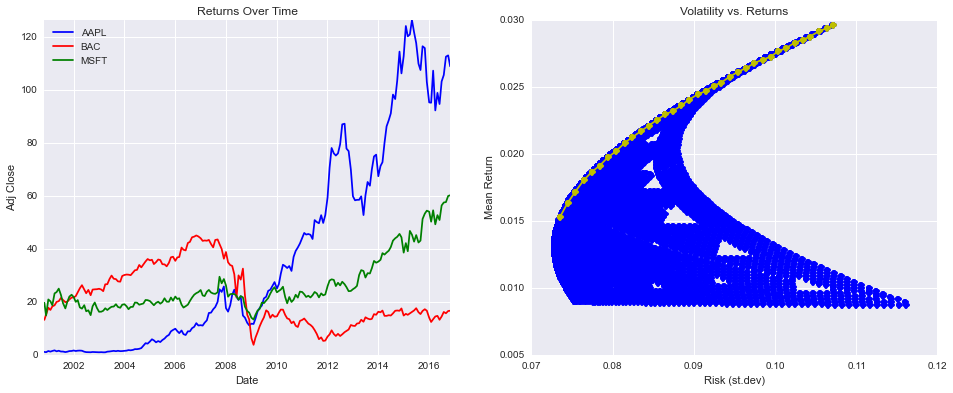

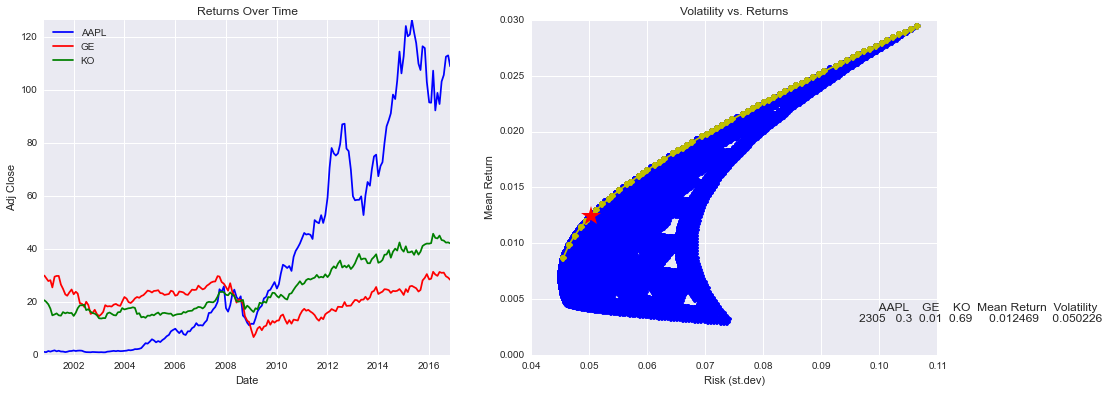

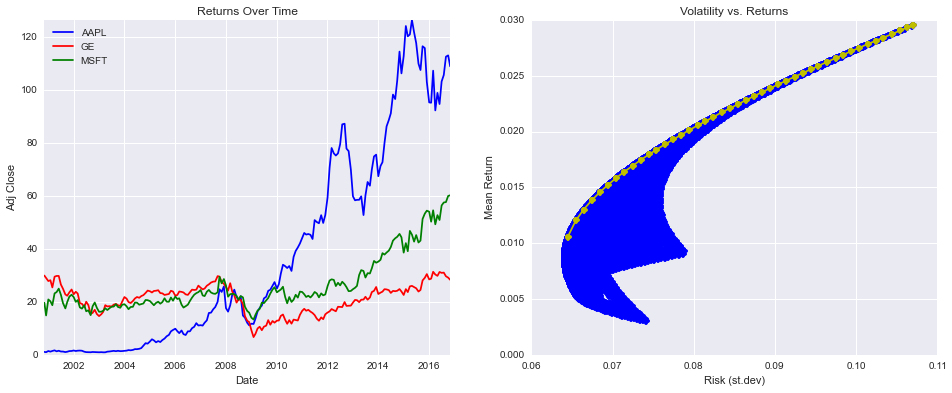

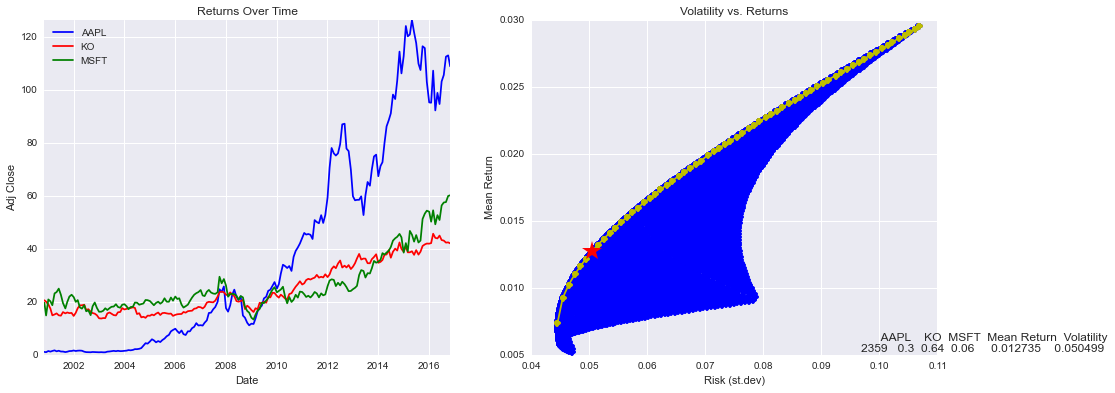

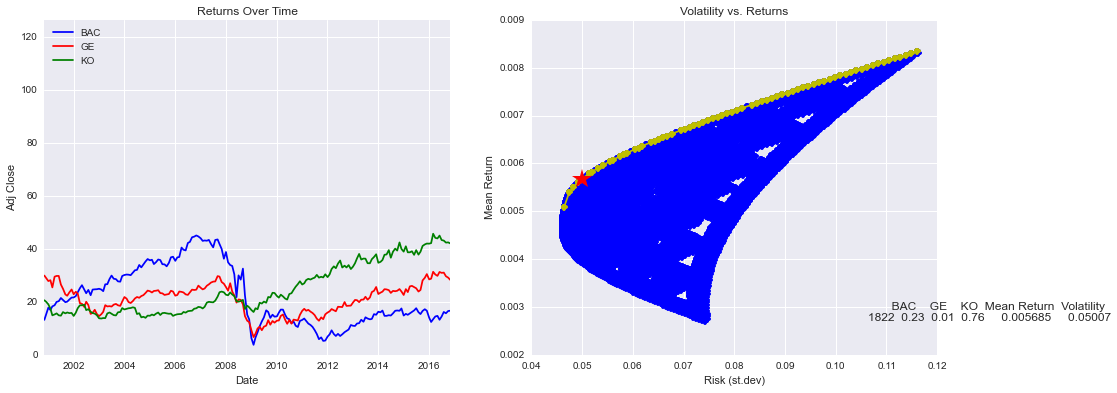

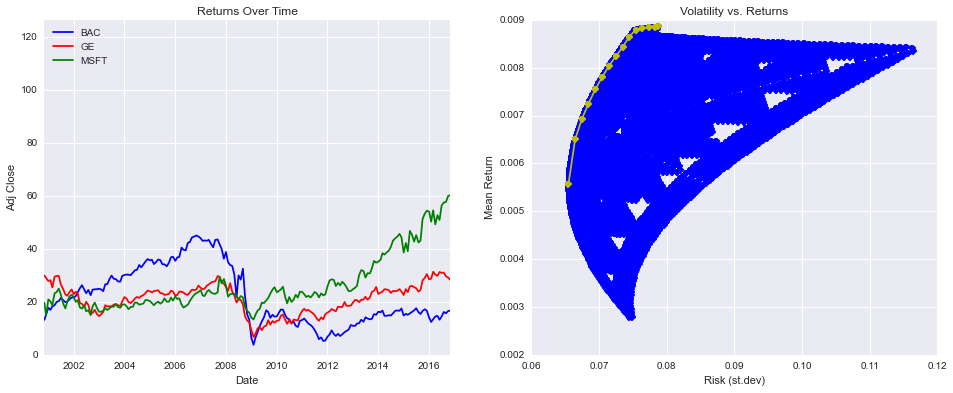

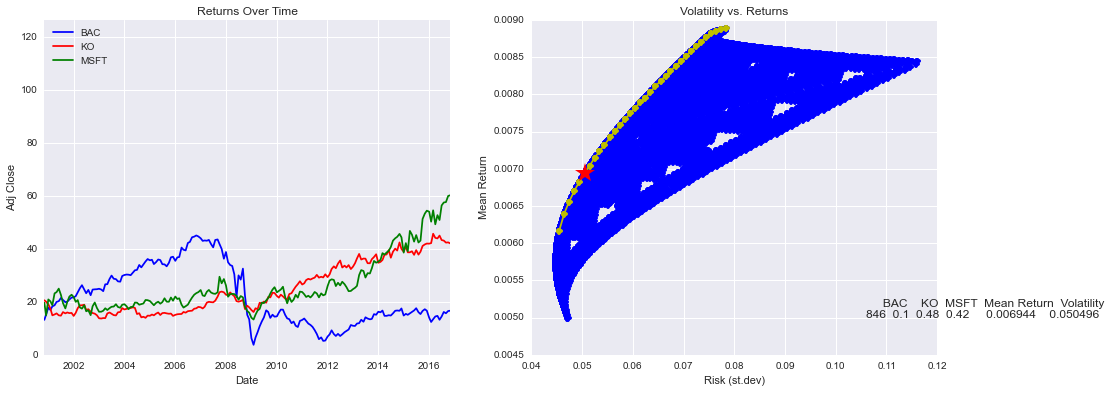

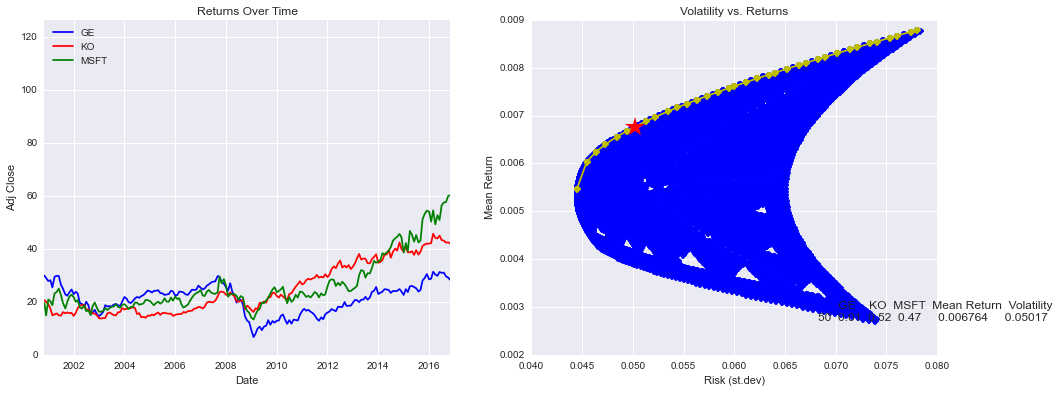

In [20]:
risk = .05
chosens = choose_risk_level(risk,save_results=False)
if len(chosens):
    plot(chosens,save_results=False)

### Notes: